In [66]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [67]:
%cd /gdrive/My\ Drive/Monte_Carlo_Light_Scattering

/gdrive/My Drive/Monte_Carlo_Light_Scattering


In [68]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
import cv2

In [ ]:
mnist = tf.keras.datasets.mnist
(x_train,y_train),(x_test,y_test) = mnist.load_data()
x_train = tf.keras.utils.normalize(x_train , axis =1)
x_test = tf.keras.utils.normalize(x_test , axis =1)
x_train = x_train[:2000]
x_test = x_test[:200]
y_train = y_train[:2000]
y_test = y_test[:200]

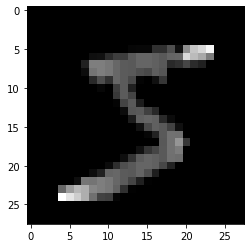

In [ ]:
for i in range(len(x_train)):
    x_train[i] = 1 - x_train[i]
for i in range(len(x_test)):
    x_test[i] = 1 - x_test[i]
plt.imshow(x_train[0], cmap = plt.cm.binary)
plt.show()

In [1]:
def mc_sim(x_train, size=64, launch="iso", length=0.25, thres=0.01): #length is in cm
    x, y, z = 0, 0, 0
    ux, uy, uz = 0, 0, 0
    W = 0
    mua = 1.673 #cm^-1
    mus = 110   #cm^-1
    g = 0.9
    albedo = mus / (mus + mua)
    output = np.zeros((size, size))

    for i in range(size):
        for j in range(size):

            if launch == "col":
                # COLLIMATED LAUNCH
                W = x_train[i][j]
                x = i
                y = j
                z = 0
                uz = 1
            if launch == "iso":
                # ISOTROPIC LAUNCH
                W = x_train[i][j]
                x = i
                y = j
                z = 0

                costheta = 2 * np.random.rand() - 1
                sintheta = np.sqrt(1 - costheta ** 2)
                psi = 2 * np.pi * np.random.rand()
                ux = sintheta * np.cos(psi)
                uy = sintheta * np.sin(psi)
                uz = costheta

            while length > z > -0.1:
                # HOP
                s = -np.log(np.random.rand()) / (mua + mus)
                x += s * ux
                y += s * uy
                z += s * uz

                # DROP
                absorb = W * (1 - albedo)
                W -= absorb
                if W <= thres:
                    break

                # SPIN/SCATTER
                rnd = np.random.rand()
                if g == 0:
                    costheta = 2 * rnd - 1
                else:
                    temp = (1 - g ** 2) / (1 - g + 2 * rnd * g)
                    costheta = (1 + g ** 2 - temp ** 2) / (2 * g)
                sintheta = np.sqrt(1 - costheta ** 2)

                psi = 2 * np.pi * np.random.rand()
                cospsi = np.cos(psi)
                if psi < np.pi:
                    sinpsi = np.sqrt(1 - cospsi ** 2)
                else:
                    sinpsi = -np.sqrt(1 - cospsi ** 2)

                if (1 - abs(uz)) <= 10 ** -12:
                    uxx = sintheta * cospsi
                    uyy = sintheta * sinpsi
                    uzz = costheta * np.sign(uz)
                else:
                    temp = np.sqrt(1 - uz ** 2)
                    uxx = sintheta * (ux * uz * cospsi - uy * sinpsi) / temp + ux * costheta
                    uyy = sintheta * (uy * uz * cospsi + ux * sinpsi) / temp + uy * costheta
                    uzz = -sintheta * cospsi * temp + uz * costheta

                ux = uxx
                uy = uyy
                uz = uzz

            x = int(np.round(x))
            y = int(np.round(y))

            if z >= length:
                if 0 <= x < size:
                    if 0 <= y < size:
                        output[x][y] = W
    return output

In [ ]:
for i in range(len(x_train)):
    x_train[i] = mc_sim(x_train[i],length=0.1, size=28)
    print((i+1)*100/len(x_train),"%")

In [ ]:
for i in range(len(x_test)):
    x_test[i] = mc_sim(x_test[i],length=0.1, size=28)
    print((i+1)*100/len(x_test),"%")

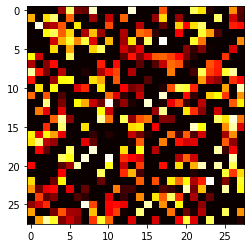

In [ ]:
plt.imshow(x_train[0], cmap='hot')
plt.show()

In [ ]:
np.save("x_train_0.1.npy",x_train)
np.save("x_test_0.1.npy",x_test)

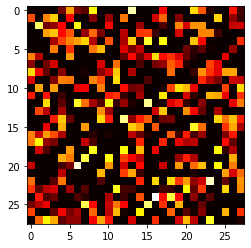

In [ ]:
x_train = tf.keras.utils.normalize(x_train , axis =1)
x_test = tf.keras.utils.normalize(x_test , axis =1)
plt.imshow(x_train[0], cmap='hot')
plt.show()

In [77]:
from keras.layers.advanced_activations import LeakyReLU
X = x_train.reshape(-1,28,28,1)
y = np.array(y_train)

dense_layer = 1
layer_size = 64
conv_layer = 2

model = Sequential()

model.add(Conv2D(layer_size, (3, 3), input_shape=X.shape[1:],padding="same"))
model.add(LeakyReLU(alpha=0.3))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

for l in range(conv_layer-1):
  model.add(Conv2D(layer_size, (3, 3),padding="same"))
  model.add(LeakyReLU(alpha=0.3))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

model.add(Flatten())

for l in range(dense_layer):
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.3))
    model.add(Dropout(0.2))

model.add(Dense(10))
model.add(Activation('softmax'))


model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X, y,
          batch_size=5,
          epochs=20)

Epoch 1/20
400/400 [==============================] - 7s 16ms/step - loss: 2.3075 - accuracy: 0.1103
Epoch 2/20
400/400 [==============================] - 6s 16ms/step - loss: 1.7085 - accuracy: 0.4208
Epoch 3/20
400/400 [==============================] - 6s 16ms/step - loss: 1.3030 - accuracy: 0.5652
Epoch 4/20
400/400 [==============================] - 6s 16ms/step - loss: 0.9708 - accuracy: 0.6834
Epoch 5/20
400/400 [==============================] - 6s 16ms/step - loss: 0.6393 - accuracy: 0.7834
Epoch 6/20
400/400 [==============================] - 6s 16ms/step - loss: 0.3461 - accuracy: 0.9014
Epoch 7/20
400/400 [==============================] - 6s 16ms/step - loss: 0.1899 - accuracy: 0.9400
Epoch 8/20
400/400 [==============================] - 6s 16ms/step - loss: 0.1194 - accuracy: 0.9692
Epoch 9/20
400/400 [==============================] - 6s 16ms/step - loss: 0.1045 - accuracy: 0.9692
Epoch 10/20
400/400 [==============================] - 6s 16ms/step - loss: 0.0781 - accura

In [78]:
X_test = x_test.reshape(-1,28,28,1)
y_test = np.array(y_test)
val_loss, val_accuracy = model.evaluate(X_test,y_test)
print(val_loss,val_accuracy)

7/7 [==============================] - 0s 17ms/step - loss: 4.4754 - accuracy: 0.3400
4.475366115570068 0.3400000035762787
